# imports

In [2]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

#import data_transforations as data_tr


In [3]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/Data2/"

## Models

In [4]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import loguniform

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from imblearn.ensemble import BalancedRandomForestClassifier



## Scoring

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Functions

In [ ]:
from sklearn.metrics import make_scorer
def my_custom_accuracy(y_true, y_pred):
    w=2
    cm = confusion_matrix(y_true, y_pred)
    true_0 =(cm[0][0]/(cm[0][0]+cm[0][1]))
    true_1= w*(cm[1][1]/(cm[1][1]+cm[1][0]))

    return (true_0+true_1)/(1+w)
custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

In [30]:
#bar comparison
def bar_comp(df,category, split):
    
    props=df.groupby(split)[category].value_counts(normalize=True).rename('proportion').reset_index()

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=props,
        x=category,
        y='proportion',
        hue=split,
        palette='viridis')  
    
    # Set the title and labels for clarity.
    plt.title(f'Proportion of {category} by {split}', fontsize=16)
    plt.xlabel(category, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.legend(title=split)

    # Add annotations to the bars to show the exact proportion.
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           fontsize=10, color='black',
                           xytext=(0, 5),
                           textcoords='offset points')

    plt.tight_layout() # Adjust layout to make room for the labels.
    plt.show()





In [80]:
def data_prep(data, model_target):

    data.drop(columns=['Unnamed: 0','reason', 'policy_type', 'has_been_recaptured','last in 3 m','securitygroup_id','# claims', 'res_code_QA_sum','res_code_claims_sum', 'res_code_update_sum','unemployment rate end','inflation end'], inplace=True)

    #imputing nulls
    fill_values = {
        '1 month ago payment': 'not incepted',
        '2 month ago payment': 'not incepted',
        '3 month ago payment': 'not incepted',
        '4 month ago payment': 'not incepted',
        '5 month ago payment': 'not incepted',
        '6 month ago payment': 'not incepted'}
    # Use the dictionary to fill missing values
    data.fillna(value=fill_values, inplace=True)
    data_info = DataPreparation(df=data)
    imp_dict={'optionality': 'mode',
                  'cover_amount_full':'mean'}
    data_info.imputating_nulls(imp_dict=imp_dict)
    data=data_info.imputed_df
    data['original_premium'] = data['original_premium'].fillna('premium')
    data['prev_premium'] = data['prev_premium'].fillna('premium')

    #creating next month lapse data sets
    if model_target == '1month':
        next_month_lapse_data = data[['age', 'benefits_count', 'education',
           'gender', 'income', 'smoker_status', 'sold_socio_economic_class',
           'optionality', 'premium',
            'original_premium','last_benefit_amount', 'last_main_premium',
           'total_funeral_premium', 'funeral_count',
           'prev_premium', 'lapse_flag', 'cover_amount_full',
            'eml', 'pml', 'current individual_income',
           'orginal individual_income',
           '* policy start delay months', '* policy duration months',
           'last premium amount due', 'duration to anniversary',
           'payment_method_DebiCheck_sum', 'payment_method_EFT_sum',
           'payment_method_Pre Fund_sum', '# anniversaries', 'payment rate',
           '1 month ago payment', '2 month ago payment', '3 month ago payment',
           '4 month ago payment', '5 month ago payment', '6 month ago payment',
            '# calls', '# calls contacted',
            'res_code_other_sum', 'res_code_payment_sum',
           'res_code_sale_sum', 'inflation start',
           'unemployment rate start']].copy()

        features=list(set(next_month_lapse_data.columns).difference('lapse_flag'))

        X = data[features].copy()
        Y = data['lapse_flag'].astype(int).copy()
        # Train Test Split
        X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

        return X_train, X_test, Y_train, y_test
    
    #creating next 3 months lapses
    elif model_target == '3month':
        next_3month_lapse_data = data[['age', 'benefits_count', 'education',
           'gender', 'income', 'smoker_status', 'sold_socio_economic_class',
           'optionality', 'premium',
            'original_premium','last_benefit_amount', 'last_main_premium',
           'total_funeral_premium', 'funeral_count',
           'prev_premium', 'lapse_flag', 'cover_amount_full',
            'eml', 'pml', 'current individual_income',
           'orginal individual_income',
           '* policy start delay months', '* policy duration months',
           'last premium amount due', 'duration to anniversary',
           'payment_method_DebiCheck_sum', 'payment_method_EFT_sum',
           'payment_method_Pre Fund_sum', '# anniversaries', 'payment rate',
           '4 month ago payment', '5 month ago payment', '6 month ago payment',
            '# calls', '# calls contacted',
            'res_code_other_sum', 'res_code_payment_sum',
           'res_code_sale_sum', 'inflation start',
           'unemployment rate start']].copy()
        next_3month_lapse_data['* policy duration months'] = next_3month_lapse_data['* policy duration months']-3
        next_3month_lapse_data['duration to anniversary']=next_3month_lapse_data['duration to anniversary']+3
        next_3month_lapse_data['duration to anniversary']=next_3month_lapse_data['duration to anniversary'].apply(lambda x: x if x<13 else x%12)

        features=list(set(next_month_lapse_data.columns).difference('lapse_flag'))
        X = data[features].copy()
        Y = data['lapse_flag'].astype(int).copy()
        # Train Test Split
        X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

        return X_train, X_test, Y_train, y_test

# Data

Target = ['1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag']

## Data for modeling

In [82]:
#imp_features=[]
target= ''
#filter=''
data=pd.DataFrame(pd.read_csv(path+"near_ftr_data_eco_6n_v2.csv"))
#class_weight = {0:1,1:1}


In [9]:
data.head()

,policy_id,policy_name,age,benefits_count,education,gender,income,smoker_status,sold_socio_economic_class,securitygroup_id,...,res_code_other_sum,res_code_payment_sum,res_code_sale_sum,res_code_update_sum,inflation start,unemployment rate start,end_date,inflation end,unemployment rate end,last in 3 m
0,100003c9-2094-3107-e604-65d8e6b4ec03,MWL008050072,51,1.0,Matric,Male,40000.0,S,1.0,MWL,...,0.0,0.0,0.0,0.0,4.5,34.300,1970-01-01 00:00:00.000002025,3.0,33.05,False
1,10000cc8-8f08-5e2c-b6ad-661d48606710,ML24-0199554,23,1.0,Matric + 3 year Diploma,Female,20000.0,N,2.0,MWL,...,0.0,0.0,0.0,0.0,4.4,32.600,1970-01-01 00:00:00.000002025,3.0,33.05,False
2,100307d2-6857-7f50-833c-66b391c37879,ML24-0254853,63,1.0,Matric + 3 year Diploma,Female,45000.0,E,1.0,MWL,...,0.0,3.0,1.0,0.0,4.4,32.600,1970-01-01 00:00:00.000002025,3.0,33.05,False
3,10048ce0-253d-aeff-4f59-64e76756bddf,ML23-0067459,41,1.0,Matric + 3 year Diploma,Male,70000.0,S,1.0,MWL,...,0.0,0.0,0.0,0.0,6.0,32.375,1970-01-01 00:00:00.000002025,3.0,33.05,False
4,10061226-ed6a-b733-47f0-65fb970086cd,MWL007912004,36,5.0,4 year Degree,Female,40000.0,N,1.0,MWL,...,0.0,0.0,0.0,0.0,4.5,34.300,1970-01-01 00:00:00.000002025,3.0,33.05,False


In [57]:
data.drop(columns=['reason', 'policy_type', 'has_been_recaptured','last in 3 m','securitygroup_id','# claims', 'res_code_QA_sum','res_code_claims_sum', 'res_code_update_sum','unemployment rate end','inflation end'], inplace=True)
data_info = DataPreparation(df=data)

In [15]:
data_info.uniq_df

,no. of unique entries
policy_id,62536
policy_name,62536
age,48
benefits_count,19
education,8
...,...
unemployment rate start,11
end_date,4
inflation end,4
unemployment rate end,4


In [19]:
data_info.null_df
#impute: 'optionality' with mode, 'orginal_premium' with premium, 'prev_premium' with premium, 'cover_amount_full' with mean, 'n month ago payment' with "NA"
#drop: 'reason', 'policy_type', 'has_been_recaptured'



,nulls,percentage nulls
policy_id,0,0.000000
policy_name,0,0.000000
age,0,0.000000
benefits_count,0,0.000000
education,0,0.000000
...,...,...
unemployment rate start,0,0.000000
end_date,0,0.000000
inflation end,0,0.000000
unemployment rate end,0,0.000000


In [58]:
fill_values = {
    '1 month ago payment': 'not incepted',
    '2 month ago payment': 'not incepted',
    '3 month ago payment': 'not incepted',
    '4 month ago payment': 'not incepted',
    '5 month ago payment': 'not incepted',
    '6 month ago payment': 'not incepted'
}
# Use the dictionary to fill missing values
data.fillna(value=fill_values, inplace=True)

imp_dict={'optionality': 'mode',
              'cover_amount_full':'mean'}
data_info.imputating_nulls(imp_dict=imp_dict)
data=data_info.imputed_df

In [59]:
data['original_premium'] = data['original_premium'].fillna('premium')
data['prev_premium'] = data['prev_premium'].fillna('premium')

In [25]:
data

,policy_id,policy_name,age,benefits_count,education,gender,income,smoker_status,sold_socio_economic_class,securitygroup_id,...,res_code_other_sum,res_code_payment_sum,res_code_sale_sum,res_code_update_sum,inflation start,unemployment rate start,end_date,inflation end,unemployment rate end,last in 3 m
0,100003c9-2094-3107-e604-65d8e6b4ec03,MWL008050072,51,1.0,Matric,Male,40000.0,S,1.0,MWL,...,0.0,0.0,0.0,0.0,4.5,34.300,1970-01-01 00:00:00.000002025,3.0,33.05,False
1,10000cc8-8f08-5e2c-b6ad-661d48606710,ML24-0199554,23,1.0,Matric + 3 year Diploma,Female,20000.0,N,2.0,MWL,...,0.0,0.0,0.0,0.0,4.4,32.600,1970-01-01 00:00:00.000002025,3.0,33.05,False
2,100307d2-6857-7f50-833c-66b391c37879,ML24-0254853,63,1.0,Matric + 3 year Diploma,Female,45000.0,E,1.0,MWL,...,0.0,3.0,1.0,0.0,4.4,32.600,1970-01-01 00:00:00.000002025,3.0,33.05,False
3,10048ce0-253d-aeff-4f59-64e76756bddf,ML23-0067459,41,1.0,Matric + 3 year Diploma,Male,70000.0,S,1.0,MWL,...,0.0,0.0,0.0,0.0,6.0,32.375,1970-01-01 00:00:00.000002025,3.0,33.05,False
4,10061226-ed6a-b733-47f0-65fb970086cd,MWL007912004,36,5.0,4 year Degree,Female,40000.0,N,1.0,MWL,...,0.0,0.0,0.0,0.0,4.5,34.300,1970-01-01 00:00:00.000002025,3.0,33.05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62531,ffaa032e-2a01-cf52-cc1a-65fb3147c393,MWL006676786,51,1.0,Matric + 3 year Diploma,Female,40000.0,N,1.0,MWL,...,0.0,0.0,6.0,0.0,4.2,28.700,1970-01-01 00:00:00.000002025,3.0,33.05,False
62532,ffb7087c-78f7-a485-5b7f-65d8d25da2c7,MWL007292690,41,1.0,Matric,Female,14000.0,N,2.0,MWL,...,0.0,0.0,0.0,0.0,3.3,29.175,1970-01-01 00:00:00.000002025,3.0,33.05,False
62533,ffd20919-303c-e88e-fb1f-65fba1578790,MWL008568948,26,2.0,Matric + 3 year Diploma,Female,14000.0,N,2.0,MWL,...,0.0,0.0,1.0,0.0,6.9,33.500,1970-01-01 00:00:00.000002025,3.0,33.05,False
62534,ffe1059c-beea-354d-27fa-6629fe94a5cf,MWL006194665,45,1.0,3 year Degree,Female,30000.0,N,1.0,MWL,...,0.0,0.0,0.0,0.0,4.7,27.125,1970-01-01 00:00:00.000002025,3.0,33.05,False


## Next month lapse

In [83]:
X_train, X_test, Y_train, y_test=data_prep(data,'1month')

In [ ]:
next_month_lapse_data = data[['age', 'benefits_count', 'education',
       'gender', 'income', 'smoker_status', 'sold_socio_economic_class',
       'optionality', 'premium',
        'original_premium','last_benefit_amount', 'last_main_premium',
       'total_funeral_premium', 'funeral_count',
       'prev_premium', 'lapse_flag', 'cover_amount_full',
        'eml', 'pml', 'current individual_income',
       'orginal individual_income',
       '* policy start delay months', '* policy duration months',
       'last premium amount due', 'duration to anniversary',
       'payment_method_DebiCheck_sum', 'payment_method_EFT_sum',
       'payment_method_Pre Fund_sum', '# anniversaries', 'payment rate',
       '1 month ago payment', '2 month ago payment', '3 month ago payment',
       '4 month ago payment', '5 month ago payment', '6 month ago payment',
        '# calls', '# calls contacted',
        'res_code_other_sum', 'res_code_payment_sum',
       'res_code_sale_sum', 'inflation start',
       'unemployment rate start']].copy()


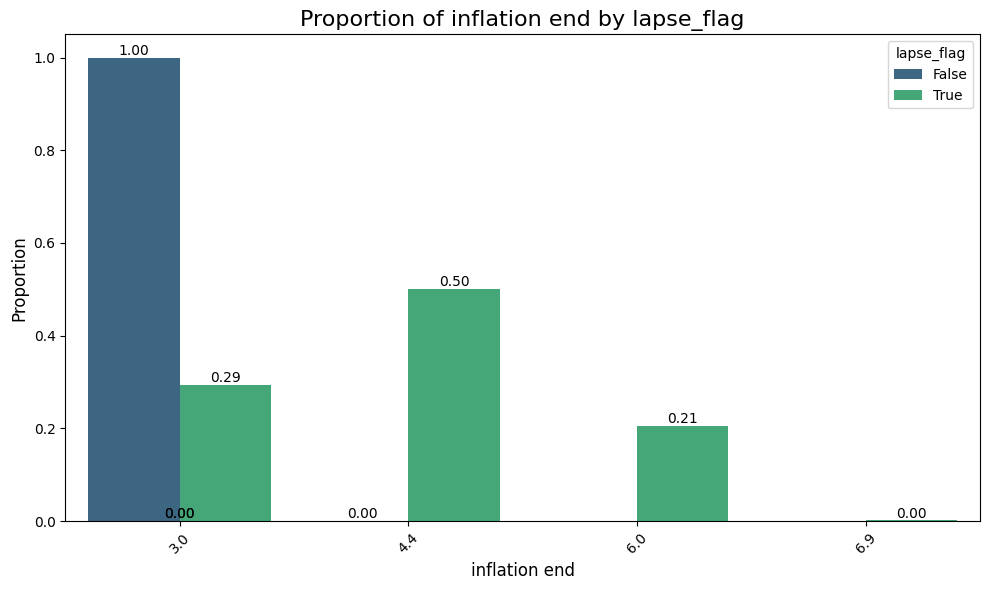

In [54]:
cat= 'inflation end'
data=next_month_lapse_data
bar_comp(data,category=cat,split='lapse_flag')

In [61]:
target='lapse_flag'
data[target].sum()*100/data[target].count()

23.610400409364207

### Scaling data

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
data_s=data.copy()

In [62]:
next_month_lapse_data.columns

Index(['age', 'benefits_count', 'education', 'gender', 'income',
       'smoker_status', 'sold_socio_economic_class', 'optionality', 'premium',
       'original_premium', 'last_benefit_amount', 'last_main_premium',
       'total_funeral_premium', 'funeral_count', 'prev_premium', 'lapse_flag',
       'cover_amount_full', 'eml', 'pml', 'current individual_income',
       'orginal individual_income', '* policy start delay months',
       '* policy duration months', 'last premium amount due',
       'duration to anniversary', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum',
       '# anniversaries', 'payment rate', '1 month ago payment',
       '2 month ago payment', '3 month ago payment', '4 month ago payment',
       '5 month ago payment', '6 month ago payment', '# calls',
       '# calls contacted', 'res_code_other_sum', 'res_code_payment_sum',
       'res_code_sale_sum', 'inflation start', 'unemployment rate start'],
      dtype='object')

In [ ]:
scale_cols=['age', 'benefits_count', 'income',
       'premium','original_premium', 'last_benefit_amount', 'last_main_premium',
       'total_funeral_premium', 'funeral_count', 'prev_premium',
       'cover_amount_full', 'eml', 'pml', 'current individual_income',
       'orginal individual_income', '* policy start delay months',
       '* policy duration months', 'last premium amount due',
       'duration to anniversary', 'payment_method_DebiCheck_sum',
       'payment_method_EFT_sum', 'payment_method_Pre Fund_sum',
       '# anniversaries', 'payment rate', '# calls',
       '# calls contacted', 'res_code_other_sum', 'res_code_payment_sum',
       'res_code_sale_sum', 'inflation start', 'unemployment rate start']
data_s[scale_cols] = scale.fit_transform(data_s[scale_cols])

In [ ]:
X_train,x_test, Y_train, y_test = data_prep(data_s,target,filter=filter)

### try resampling SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy=0.6,random_state=42)
X_smote, Y_smote = sm.fit_resample(X_train.copy(), Y_train.copy())

#X_train=X_smote.copy()
#Y_train=Y_smote.copy()

In [ ]:
Y_smote.sum()*100/Y_smote.count()

37.49569114098587

## Next 3 months lapse